In [1]:
import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

In [2]:
import frugal_flows

In [3]:
from frugal_flows.flows import masked_independent_flow, masked_autoregressive_flow_first_uniform
from frugal_flows.bijections import UnivariateNormalCDF

In [4]:
from flowjax.distributions import Transformed, Uniform, _StandardUniform
from flowjax.flows import masked_autoregressive_flow
from flowjax.train import fit_to_data
from flowjax.bijections.utils import Identity
from flowjax.wrappers import NonTrainable
from flowjax.bijections import (
    Affine,
    Invert,
    MaskedAutoregressive,
    RationalQuadraticSpline,
    Stack,
    Tanh,
)

In [5]:
SEED = 0

# Generate data

In [6]:
# gen data

key, subkey = jr.split(jr.PRNGKey(SEED))

y = jr.normal(subkey, shape=(5000,1)) #+ x

z = jr.multivariate_normal(key, jnp.array([0.,0.]), jnp.array([[1., 0.8],[0.8, 1.]]), shape=(5000,))

# Independent Marginal flows

 17%|███████████████▍                                                                          | 12/70 [00:07<00:37,  1.56it/s, train=2.853412, val=2.803351 (Max patience reached)]


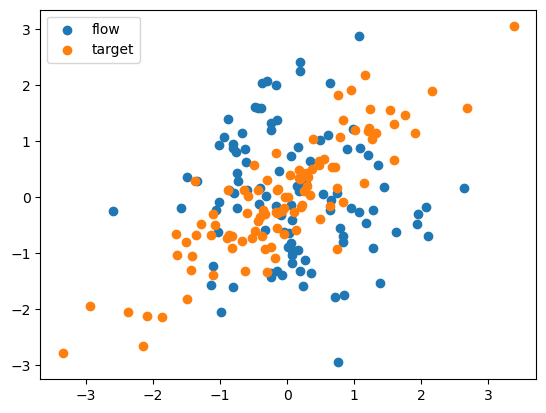

In [7]:
nvars = 2
key, subkey = jr.split(jr.PRNGKey(SEED + 1))

base_dist = Uniform(-jnp.ones(nvars), jnp.ones(nvars))

transformer = RationalQuadraticSpline(knots=8, interval=1)

flow = masked_independent_flow(#masked_autoregressive_flow(
    key=subkey,
    base_dist=base_dist,
    transformer=transformer,
    ) # Support on [-1, 1]

flow = Transformed(
    flow, Invert(Tanh(flow.shape))
) # Unbounded support


flow = flow.merge_transforms()

assert isinstance(flow.base_dist, _StandardUniform)

flow = eqx.tree_at(
    where=lambda flow: flow.bijection.bijections[0],
    pytree=flow,
    replace_fn=NonTrainable,
    )

key, subkey = jr.split(key)

# Train 
flow, losses = fit_to_data(
    key=subkey,
    dist=flow,
    x=z,
    learning_rate=1e-3,
    max_patience=10,
    max_epochs=70,
)

plt.scatter(*flow.sample(key, (100, )).T, label="flow")
plt.scatter(*z[:100].T, label="target")
plt.legend()

In [8]:
marginal_cdf = jax.vmap(flow.bijection.inverse, in_axes=(0,))

In [9]:
u_z = marginal_cdf(z)

# Copula flow given marginal

 73%|█████████████████████████████████████████████████████████████▏                      | 51/70 [00:13<00:05,  3.78it/s, train=-0.51961666, val=-0.47519666 (Max patience reached)]


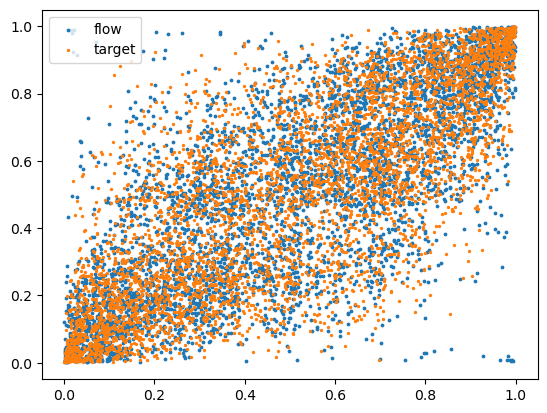

In [10]:
nvars = 2
key, subkey = jr.split(jr.PRNGKey(SEED + 2))

base_dist = Uniform(-jnp.ones(nvars), jnp.ones(nvars))

transformer = RationalQuadraticSpline(knots=8, interval=1)

copula_flow = masked_autoregressive_flow(#masked_autoregressive_flow(
    key=subkey,
    base_dist=base_dist,
    transformer=transformer,
    ) # Support on [-1, 1]

copula_flow = Transformed(
    copula_flow, Invert(Affine(loc=-jnp.ones(nvars), scale=jnp.ones(nvars)*2))
) # Unbounded support


copula_flow = copula_flow.merge_transforms()

assert isinstance(copula_flow.base_dist, _StandardUniform)

copula_flow = eqx.tree_at(
    where=lambda copula_flow: copula_flow.bijection.bijections[0],
    pytree=copula_flow,
    replace_fn=NonTrainable,
    )

copula_flow = eqx.tree_at(
    where=lambda copula_flow: copula_flow.bijection.bijections[-1],
    pytree=copula_flow,
    replace_fn=NonTrainable,
    )

key, subkey = jr.split(key)

# Train 
copula_flow, losses = fit_to_data(
    key=subkey,
    dist=copula_flow,
    x=u_z,
    learning_rate=1e-3,
    max_patience=10,
    max_epochs=70,
)

plt.scatter(*copula_flow.sample(key, (5000, )).T, label="flow", s=3)
plt.scatter(*u_z.T, label="target", s=2)
plt.legend()

In [11]:
inv_copula_cdf = jax.vmap(copula_flow.bijection.inverse, in_axes=(0,))
uu = inv_copula_cdf(u_z)

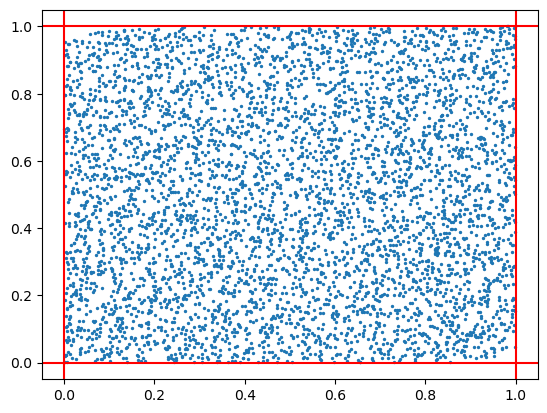

In [12]:
plt.scatter(*(uu.T), label="inverse flow", s=2,)
plt.axhline(0, color='red')
plt.axhline(1, color='red')
plt.axvline(0, color='red')
plt.axvline(1, color='red')
plt.show()

# copula flow + marginal Y) given other marginals

In [13]:
list_bijections = [UnivariateNormalCDF(ate=5., scale=2.)] + [Identity(())]*2  


marginal_transform = Stack(list_bijections)

nvars = 2
key, subkey = jr.split(jr.PRNGKey(SEED + 3))

base_dist = Uniform(-jnp.ones(nvars+1), jnp.ones(nvars+1))

transformer = RationalQuadraticSpline(knots=8, interval=1)

copula_flow = masked_autoregressive_flow_first_uniform(#masked_autoregressive_flow(
    key=subkey,
    base_dist=base_dist,
    transformer=transformer,
    invert=True,
    # cond_dim=x.shape[1],
    ) # Support on [-1, 1]

copula_flow = Transformed(
    copula_flow, Invert(Affine(loc=-jnp.ones(nvars+1), scale=jnp.ones(nvars+1)*2))
) # Unbounded support



copula_flow = Transformed(
    copula_flow, Invert(marginal_transform),
) # Unbounded support


copula_flow = copula_flow.merge_transforms()

assert isinstance(copula_flow.base_dist, _StandardUniform)

copula_flow = eqx.tree_at(
    where=lambda copula_flow: copula_flow.bijection.bijections[0],
    pytree=copula_flow,
    replace_fn=NonTrainable,
    )

copula_flow = eqx.tree_at(
    where=lambda copula_flow: copula_flow.bijection.bijections[-2],
    pytree=copula_flow,
    replace_fn=NonTrainable,
    )

key, subkey = jr.split(key)

# Train 
copula_flow, losses = fit_to_data(
    key=subkey,
    dist=copula_flow,
    x=jnp.hstack([y, u_z]),
    learning_rate=1e-3,
    max_patience=70,
    max_epochs=300,
    # condition=x,
)

 72%|█████████████████████████████████████████████████████████████▋                        | 215/300 [00:38<00:15,  5.59it/s, train=0.8732976, val=0.9628674 (Max patience reached)]


### samples from the copula flow 

In [14]:
copula_flow_samples = copula_flow.sample(key, (5000,))#, condition=u_1) #
copula_flow_samples.shape

(5000, 3)

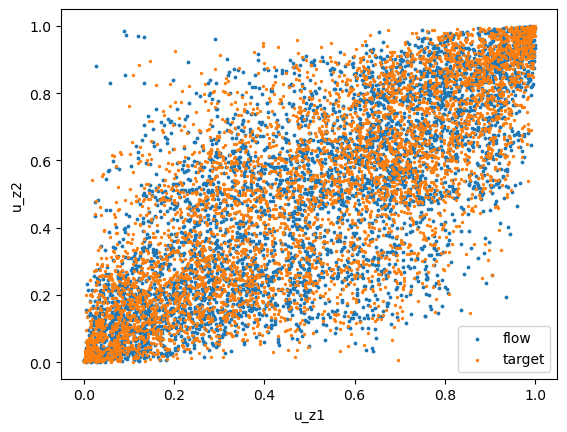

In [15]:
plt.scatter(*copula_flow_samples[:,1:].T, label="flow", s=3)
plt.scatter(*u_z.T, label="target", s=2)
plt.xlabel('u_z1')
plt.ylabel('u_z2')
plt.legend()
plt.show()

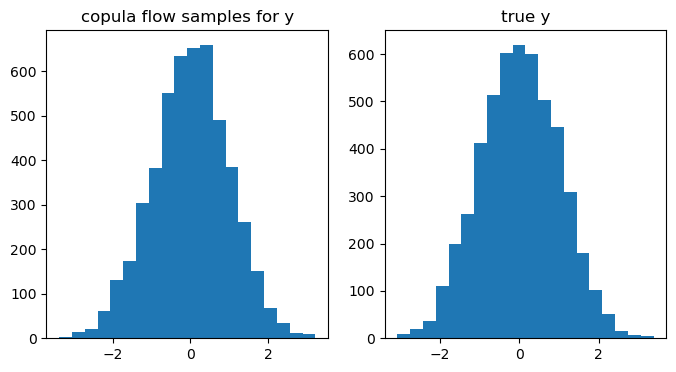

In [16]:
fig,ax =plt.subplots(1,2, figsize=(8,4))
ax[0].hist(copula_flow_samples[:,0], label="flow", bins=20)
ax[0].set_title('copula flow samples for y')

ax[1].hist(y.flatten(), label="flow", bins=20)
ax[1].set_title('true y')
# sns.kdeplot(yy,  color='red', ax=ax[1])
plt.show()

In [17]:
copula_flow.bijection.bijections[-1].bijection.bijections[0].ate, copula_flow.bijection.bijections[-1].bijection.bijections[0].scale

(Array(0.03610904, dtype=float32), Array(0.9955657, dtype=float32))

### pushing base distribution through the flow

In [18]:
uni_s = jr.uniform(key, shape=(5000,3))

In [19]:
uni_m1p1 = jax.vmap(copula_flow.bijection.bijections[0].tree.transform)(uni_s)
corruni_m1p1 = jax.vmap(copula_flow.bijection.bijections[1].transform)(uni_m1p1) #, u_1)#, x)

In [20]:
corruni_01 = jax.vmap(copula_flow.bijection.bijections[2].tree.transform)(corruni_m1p1) #, u_1) #, x)

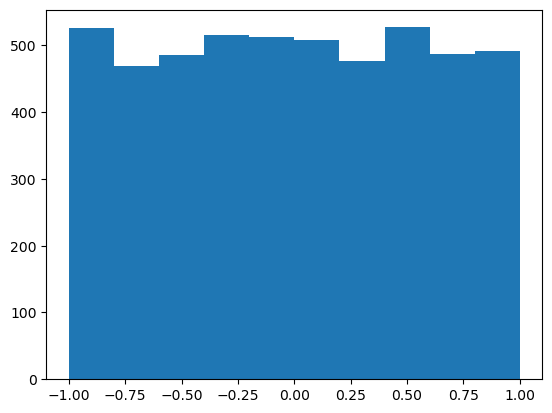

In [21]:
plt.hist(corruni_m1p1[:,0]);

# copula flow + marginal Y|do(X) given other marginals, adding X conditioning

In [136]:
dim = 3 # z dimension or input dimension
cond_dim = 2 # x dimension or condition dimension
nn_width = 5 # k or s
mlp_depth = 1
num_params = 1

In [141]:
if cond_dim is None:
    in_ranks = jnp.arange(dim)
else:
    # we give conditioning variables rank -1 (no masking of edges to output)
    in_ranks = jnp.hstack((jnp.arange(dim), -jnp.ones(cond_dim)))
    in_ranks_always_mask_cond = jnp.hstack((jnp.arange(dim), jnp.ones(cond_dim)*(dim)))
hidden_ranks = jnp.arange(nn_width) % dim
# out_ranks = jnp.repeat(jnp.arange(dim), num_params)
out_ranks = jnp.repeat(jnp.arange(dim), num_params)

# Forms mask matrix, with 1s where the out_ranks > or >= in_ranks

In [142]:
in_ranks, hidden_ranks, out_ranks = (
    jnp.asarray(a, jnp.int32) for a in (in_ranks, hidden_ranks, out_ranks)
)

in_ranks_always_mask_cond, hidden_ranks, out_ranks = (
    jnp.asarray(a, jnp.int32) for a in (in_ranks_always_mask_cond, hidden_ranks, out_ranks)
)

In [143]:
in_ranks, in_ranks_always_mask_cond, hidden_ranks, out_ranks

(Array([ 0,  1,  2, -1, -1], dtype=int32),
 Array([0, 1, 2, 3, 3], dtype=int32),
 Array([0, 1, 2, 0, 1], dtype=int32),
 Array([0, 1, 2], dtype=int32))

In [111]:
mlp = eqx.nn.MLP(
    key=jr.PRNGKey(7),
    in_size=len(in_ranks),
    out_size=len(out_ranks),
    width_size=len(hidden_ranks),
    depth=mlp_depth,
)

In [144]:
ranks = [in_ranks, *[hidden_ranks] * mlp.depth, out_ranks]
ranks_mask_cond = [in_ranks_always_mask_cond, *[hidden_ranks] * mlp.depth, out_ranks]

In [145]:
from flowjax.masks import rank_based_mask
from flowjax.wrappers import Where

In [146]:
i = 0
mlp.layers[i]

mask0 = rank_based_mask(ranks[i], ranks[i + 1], eq=i != len(mlp.layers) - 1)
mask0

Array([[ True, False, False,  True,  True],
       [ True,  True, False,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True, False, False,  True,  True],
       [ True,  True, False,  True,  True]], dtype=bool)

In [147]:
i = 0
mlp.layers[i]

mask0_mask_cond = rank_based_mask(ranks_mask_cond[i], ranks_mask_cond[i + 1], eq=i != len(mlp.layers) - 1)
mask0_mask_cond

Array([[ True, False, False, False, False],
       [ True,  True, False, False, False],
       [ True,  True,  True, False, False],
       [ True, False, False, False, False],
       [ True,  True, False, False, False]], dtype=bool)

In [148]:
i = 1

mlp.layers[i]

mask1 =rank_based_mask(ranks[i], ranks[i + 1], eq=i != len(mlp.layers) - 1)
mask1

Array([[False, False, False, False, False],
       [ True, False, False,  True, False],
       [ True,  True, False,  True,  True]], dtype=bool)

In [149]:
i = 1

mlp.layers[i]

mask1_mask_cond =rank_based_mask(ranks_mask_cond[i], ranks_mask_cond[i + 1], eq=i != len(mlp.layers) - 1)
mask1_mask_cond

Array([[False, False, False, False, False],
       [ True, False, False,  True, False],
       [ True,  True, False,  True,  True]], dtype=bool)

In [150]:
mask0.shape, mask1.shape

((5, 5), (3, 5))

In [151]:
(mask1_mask_cond.astype(int))@(mask0_mask_cond.astype(int))

Array([[0, 0, 0, 0, 0],
       [2, 0, 0, 0, 0],
       [4, 2, 0, 0, 0]], dtype=int32)

In [152]:
(mask1.astype(int))@(mask0.astype(int))

Array([[0, 0, 0, 0, 0],
       [2, 0, 0, 2, 2],
       [4, 2, 0, 4, 4]], dtype=int32)

In [153]:
mask1_mask_cond@mask0_mask_cond

Array([[False, False, False, False, False],
       [ True, False, False, False, False],
       [ True,  True, False, False, False]], dtype=bool)

In [154]:
mask1@mask0

Array([[False, False, False, False, False],
       [ True, False, False,  True,  True],
       [ True,  True, False,  True,  True]], dtype=bool)

In [134]:
masked_layers = []
for i, linear in enumerate(mlp.layers):
    mask = rank_based_mask(ranks[i], ranks[i + 1], eq=i != len(mlp.layers) - 1)
    masked_linear = eqx.tree_at(
        lambda linear: linear.weight, linear, Where(mask, linear.weight, 0)
    )
    masked_layers.append(masked_linear)

In [135]:
masked_layers_mask_cond = []
for i, linear in enumerate(mlp.layers):
    mask_mask_cond = rank_based_mask(ranks_mask_cond[i], ranks_mask_cond[i + 1], eq=i != len(mlp.layers) - 1)
    masked_linear_mask_cond = eqx.tree_at(
        lambda linear: linear.weight, linear, Where(mask, linear.weight, 0)
    )
    masked_layers_mask_cond.append(masked_linear_mask_cond)

In [62]:
z.sum(1)

Array([0.5217528 , 3.2305937 , 1.2480239 , ..., 0.8697543 , 1.7601173 ,
       0.22655085], dtype=float32)

In [64]:
ps = jax.nn.sigmoid(z.sum(1))
ps

Array([0.6275575 , 0.9619695 , 0.77695763, ..., 0.70469457, 0.85322434,
       0.55639666], dtype=float32)

In [67]:
jr.bernoulli(subkey, p=ps, ).astype(int).shape

(5000,)

In [90]:
# gen data

key, subkey = jr.split(jr.PRNGKey(SEED+6))

# x = jr.bernoulli(subkey, p=0.5, shape=(5000, 1)).astype(int)
ps = jax.nn.sigmoid(z.sum(1))
x = jnp.expand_dims(jr.bernoulli(subkey, p=ps, ).astype(int), axis=1)

# # x = jr.multivariate_normal(key, jnp.array([0.,0.]), jnp.array([[1., 0.8],[0.8, 1.]]), shape=(5000,))

key, subkey = jr.split(key)
y = jr.normal(subkey, shape=(5000,1)) + x + jnp.expand_dims(z.sum(1), axis=1)

In [91]:
y.shape

(5000, 1)

In [113]:
list_bijections = [UnivariateNormalCDF(ate=5., scale=2.)] + [Identity(())]*2  


marginal_transform = Stack(list_bijections)

nvars = 2
key, subkey = jr.split(jr.PRNGKey(SEED + 4))

base_dist = Uniform(-jnp.ones(nvars+1), jnp.ones(nvars+1))

transformer = RationalQuadraticSpline(knots=8, interval=1)

copula_flow = masked_autoregressive_flow_first_uniform(#masked_autoregressive_flow(
    key=subkey,
    base_dist=base_dist,
    transformer=transformer,
    invert=True,
    cond_dim_mask=x.shape[1],
    # cond_dim_nomask=x.shape[1],
    # cond_dim=x.shape[1],
    ) # Support on [-1, 1]

copula_flow = Transformed(
    copula_flow, Invert(Affine(loc=-jnp.ones(nvars+1), scale=jnp.ones(nvars+1)*2))
) # Unbounded support



copula_flow = Transformed(
    copula_flow, Invert(marginal_transform),
) # Unbounded support


copula_flow = copula_flow.merge_transforms()

assert isinstance(copula_flow.base_dist, _StandardUniform)

copula_flow = eqx.tree_at(
    where=lambda copula_flow: copula_flow.bijection.bijections[0],
    pytree=copula_flow,
    replace_fn=NonTrainable,
    )

copula_flow = eqx.tree_at(
    where=lambda copula_flow: copula_flow.bijection.bijections[-2],
    pytree=copula_flow,
    replace_fn=NonTrainable,
    )

key, subkey = jr.split(key)

# Train 
copula_flow, losses = fit_to_data(
    key=subkey,
    dist=copula_flow,
    x=jnp.hstack([y, u_z]),
    learning_rate=1e-3,
    max_patience=70,
    max_epochs=300,
    condition=x,
)

 54%|██████████████████████████████████████████████▏                                       | 161/300 [00:29<00:25,  5.37it/s, train=1.5746078, val=1.6423197 (Max patience reached)]


### samples from the copula flow 

In [114]:
copula_flow_samples = copula_flow.sample(key, condition=x) #
copula_flow_samples.shape

(5000, 3)

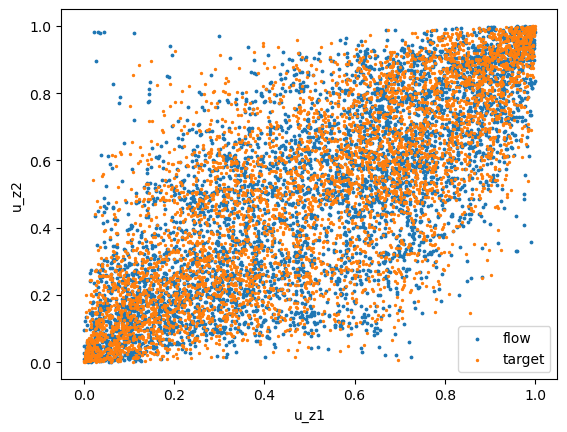

In [115]:
plt.scatter(*copula_flow_samples[:,1:].T, label="flow", s=3)
plt.scatter(*u_z.T, label="target", s=2)
plt.xlabel('u_z1')
plt.ylabel('u_z2')
plt.legend()
plt.show()

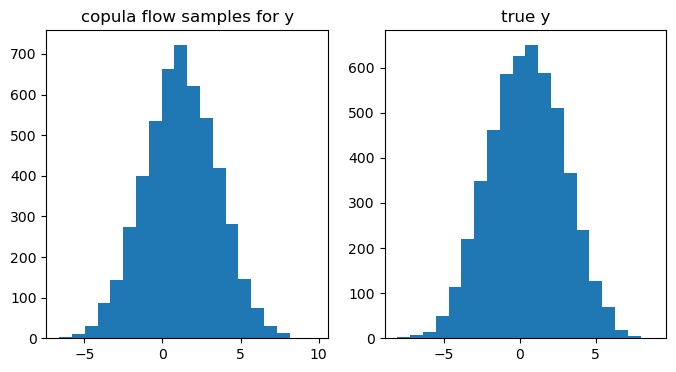

In [116]:
fig,ax =plt.subplots(1,2, figsize=(8,4))
ax[0].hist(copula_flow_samples[:,0], label="flow", bins=20)
ax[0].set_title('copula flow samples for y')

ax[1].hist(y.flatten(), label="flow", bins=20)
ax[1].set_title('true y')
# sns.kdeplot(yy,  color='red', ax=ax[1])
plt.show()

In [117]:
copula_flow.bijection.bijections[-1].bijection.bijections[0].ate, copula_flow.bijection.bijections[-1].bijection.bijections[0].scale

(Array(2.258026, dtype=float32), Array(2.001012, dtype=float32))

In [118]:
n_samples = 10000
copula_flow_samples_1 = copula_flow.sample(key, condition=jnp.ones((n_samples,1)))
copula_flow_samples_0 = copula_flow.sample(key, condition=jnp.zeros((n_samples,1)))

In [119]:
print(copula_flow_samples_1[:,0].mean())

2.2473707


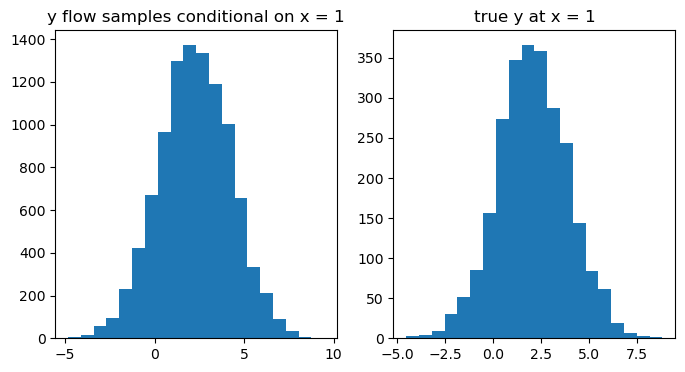

In [120]:
fig,ax =plt.subplots(1,2, figsize=(8,4))
ax[0].set_title('y flow samples conditional on x = 1')
ax[0].hist(copula_flow_samples_1[:,0], label="flow", bins=20)

ax[1].set_title('true y at x = 1')
ax[1].hist(y[x==1], label="flow", bins=20)
# sns.kdeplot(yy,  color='red', ax=ax[1])
plt.show()

In [121]:
print(copula_flow_samples_0[:,0].mean())

-0.010655016


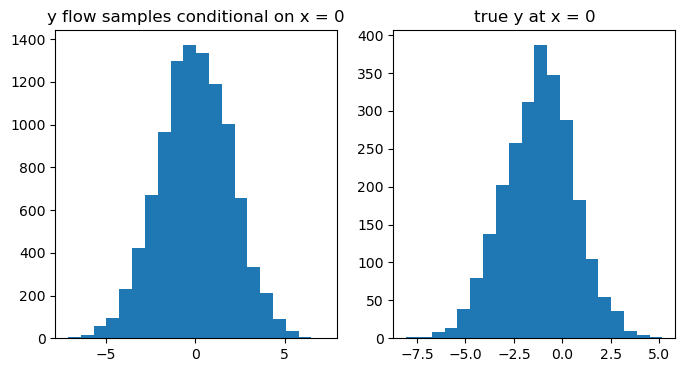

In [122]:
fig,ax =plt.subplots(1,2, figsize=(8,4))
ax[0].set_title('y flow samples conditional on x = 0')
ax[0].hist(copula_flow_samples_0[:,0], label="flow", bins=20)

ax[1].set_title('true y at x = 0')
ax[1].hist(y[x==0], label="flow", bins=20)
# sns.kdeplot(yy,  color='red', ax=ax[1])
plt.show()

### pushing base distribution through the flow

In [123]:
uni_s = jr.uniform(key, shape=(5000,3))

In [124]:
uni_m1p1 = jax.vmap(copula_flow.bijection.bijections[0].tree.transform)(uni_s)
corruni_m1p1 = jax.vmap(copula_flow.bijection.bijections[1].transform)(uni_m1p1, x)#, x)

In [125]:
corruni_01 = jax.vmap(copula_flow.bijection.bijections[2].tree.transform)(corruni_m1p1, x) #, x)

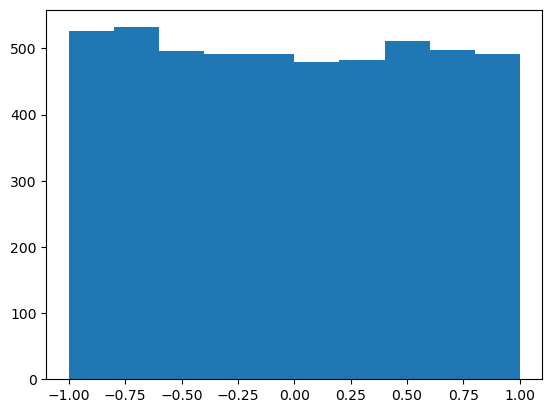

In [126]:
plt.hist(corruni_m1p1[:,0]);